In [106]:
import os, sys
currentdir = os.path.dirname(os.path.realpath('testing_pipeline.ipynb'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

from importlib import reload  
import numpy as np
from skimage.io import imread, imshow
import random
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Concatenate, concatenate, Dropout, LeakyReLU, Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda

from src import pipeline
pipeline = reload(pipeline)

In [70]:
# very complicated way to plot
# https://stackoverflow.com/questions/21754976/ipython-notebook-arrange-plots-horizontally
from IPython.display import HTML
import io
import base64

class FlowLayout(object):
    ''' A class / object to display plots in a horizontal / flow layout below a cell '''
    def __init__(self):
        # string buffer for the HTML: initially some CSS; images to be appended
        self.sHtml =  """
        <style>
        .floating-box {
        display: inline-block;
        margin: 10px;
        border: 3px solid #888888;  
        }
        </style>
        """

    def add_plot(self, oAxes):
        ''' Saves a PNG representation of a Matplotlib Axes object '''
        Bio=io.BytesIO() # bytes buffer for the plot
        fig = oAxes.get_figure()
        fig.canvas.print_png(Bio) # make a png of the plot in the buffer

        # encode the bytes as string using base 64 
        sB64Img = base64.b64encode(Bio.getvalue()).decode()
        self.sHtml+= (
            '<div class="floating-box">'+ 
            '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
            '</div>')

    def PassHtmlToCell(self):
        ''' Final step - display the accumulated HTML '''
        display(HTML(self.sHtml))


In [71]:
# Custom Keras layer

class SpaceToDepth(tf.keras.layers.Layer):

    def __init__(self, block_size, **kwargs):
        self.block_size = block_size
        super(SpaceToDepth, self).__init__(**kwargs)

    def call(self, inputs):
        x = inputs
        batch, height, width, depth = K.int_shape(x)
        batch = -1
        reduced_height = height // self.block_size
        reduced_width = width // self.block_size
        y = K.reshape(x, (batch, reduced_height, self.block_size,
                             reduced_width, self.block_size, depth))
        z = K.permute_dimensions(y, (0, 1, 3, 2, 4, 5))
        t = K.reshape(z, (batch, reduced_height, reduced_width, depth * self.block_size **2))
        return t

    def compute_output_shape(self, input_shape):
        shape =  (input_shape[0], input_shape[1] // self.block_size, input_shape[2] // self.block_size,
                  input_shape[3] * self.block_size **2)
        return tf.TensorShape(shape)
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'block_size': self.block_size,
        })
        return config

# Unet Mask

In [31]:
path = '../data/stacking/slice_test'
unet_model = '../data/weights/model_unet_checkpoint.h5'
yolo2_model = '../data/weights/yolo2_model.h5'
input_img = '../data/stacking/SCAN_2021-03-05_15-50-16/2021-03-05_15-50-16_0_0_5578.jpeg'
output_dir = '../data/stacking/slice_test'

In [32]:
pipeline.slice_img(input_img, output_dir, resize_factor = 0.2,
                  slice_height = 256, slice_width = 256,
                  zero_frac_tresh = 0.8, overlap = 0, pad = 0, verbose = True)

Directory  ../data/stacking/slice_test  already exists
dx 256
dy 256
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_0_256_256_0.png
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_256_256_256_0.png
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_400_256_256_0.png
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_237_0_256_256_0.png
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_237_256_256_256_0.png
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_237_400_256_256_0.png
Num slices: 6 Num non-null slices: 0 sliceHeight 256 sliceWidth 256


In [33]:
imgs, sizes_imgs  = pipeline.get_imgs(path)

In [34]:
pred_masks_t = pipeline.unet_predict(unet_model, imgs, sizes_imgs)

1/1 [==============================] - 0s 306ms/step



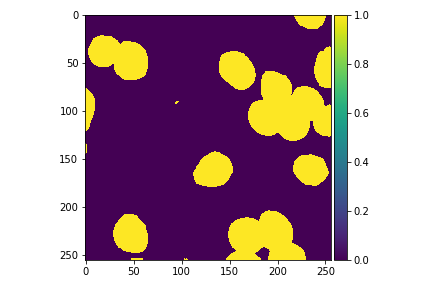
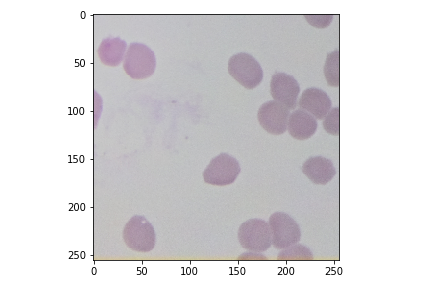
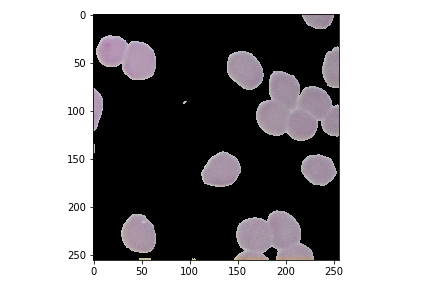

In [35]:
#pretty complicated just so we can plot next to each other
oPlot = FlowLayout() # create an empty FlowLayout

# Perform check on test set
ix = random.randint(0, len(pred_masks_t)-1)
oPlot.add_plot(imshow(np.squeeze(pred_masks_t[ix])))
plt.close() 
oPlot.add_plot(imshow(imgs[ix]))
plt.close() 
image_overlayed = np.where(np.squeeze(pred_masks_t[ix])[...,None], imgs[ix], 0)
oPlot.add_plot(imshow(image_overlayed)) # pass it to the FlowLayout to save as an image
plt.close() # this gets rid of the plot so it doesn't appear in the cell

oPlot.PassHtmlToCell()


In [36]:
num_labels, labels = cv2.connectedComponents(np.squeeze(pred_masks_t[ix]))

In [37]:
num_labels

15


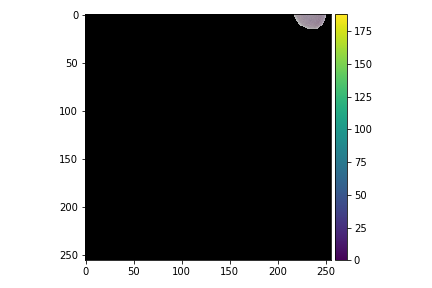
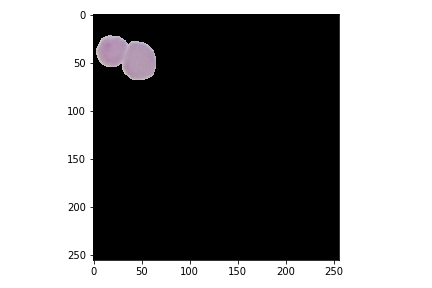
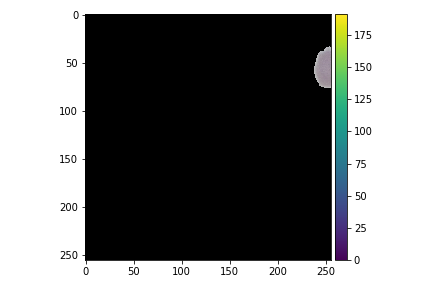
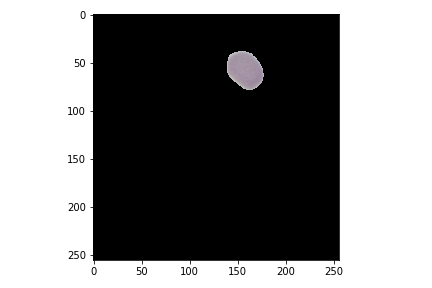
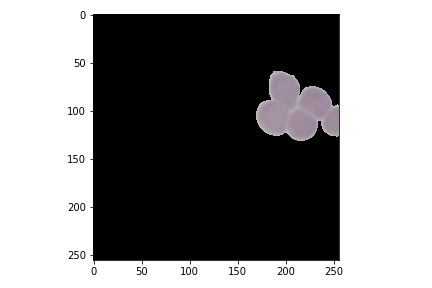
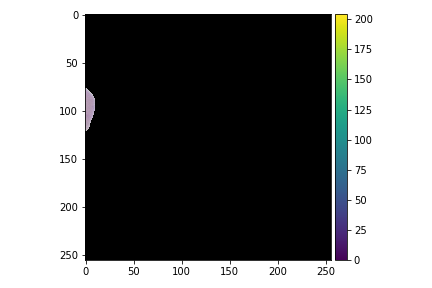
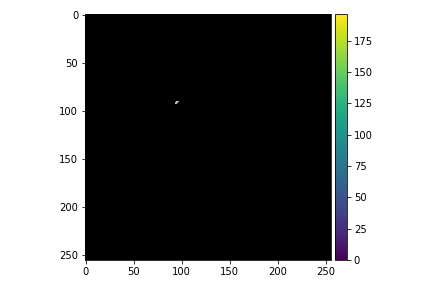
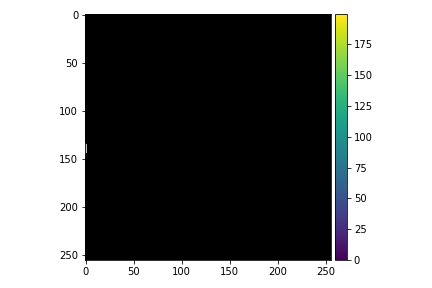
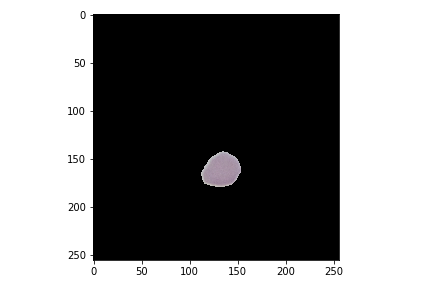
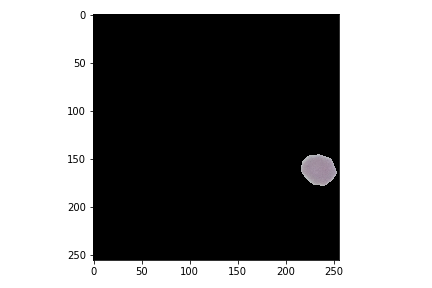
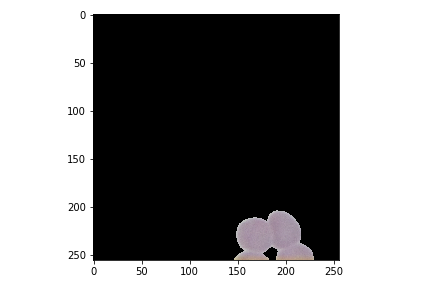
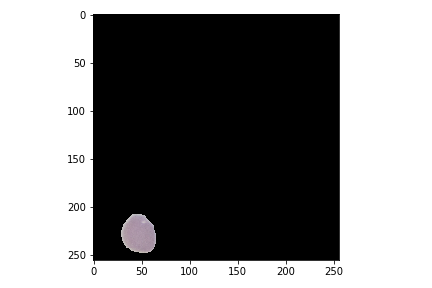
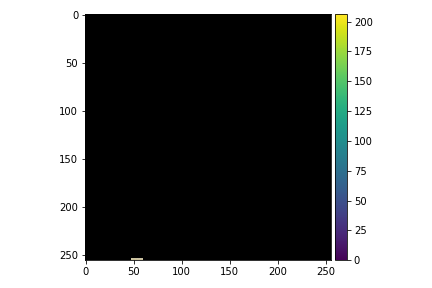
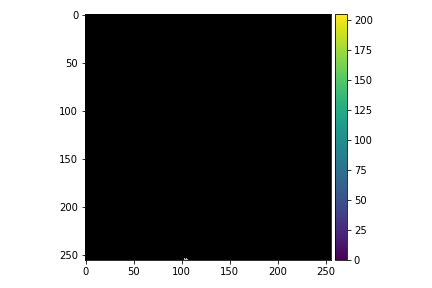

In [38]:
#pretty complicated just so we can plot next to each other
oPlot = FlowLayout() # create an empty FlowLayout

for label in range(1,num_labels):
    component = np.where(np.where(labels == label, 1, 0)[...,None], imgs[ix], 0)
    oPlot.add_plot(imshow(component)) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell

oPlot.PassHtmlToCell()

In [72]:
yolo_model = load_model(yolo2_model, custom_objects={'SpaceToDepth': SpaceToDepth})

/tf/src/pipeline.py:308: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, (ax1) = plt.subplots(1,1, figsize=(10, 10))


<Figure size 144x144 with 0 Axes>

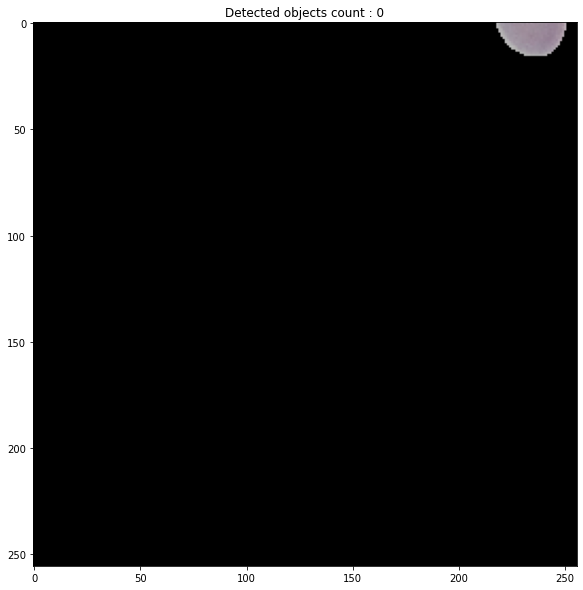

<Figure size 144x144 with 0 Axes>

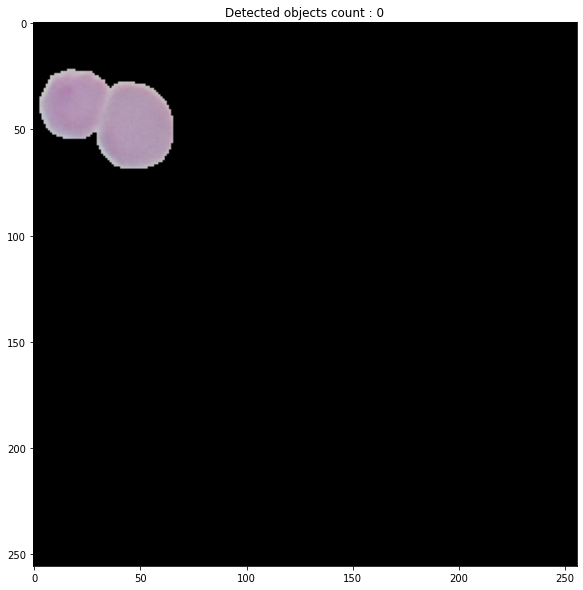

<Figure size 144x144 with 0 Axes>

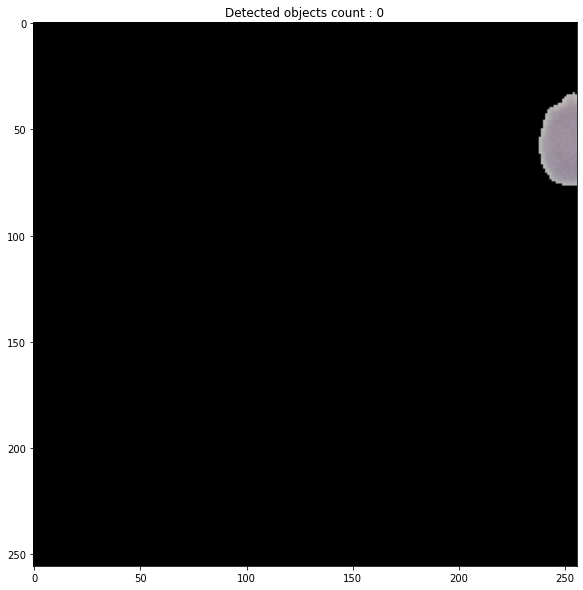

<Figure size 144x144 with 0 Axes>

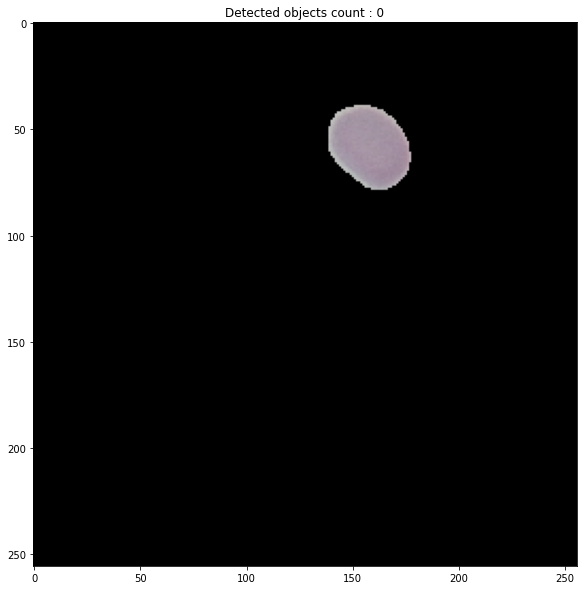

<Figure size 144x144 with 0 Axes>

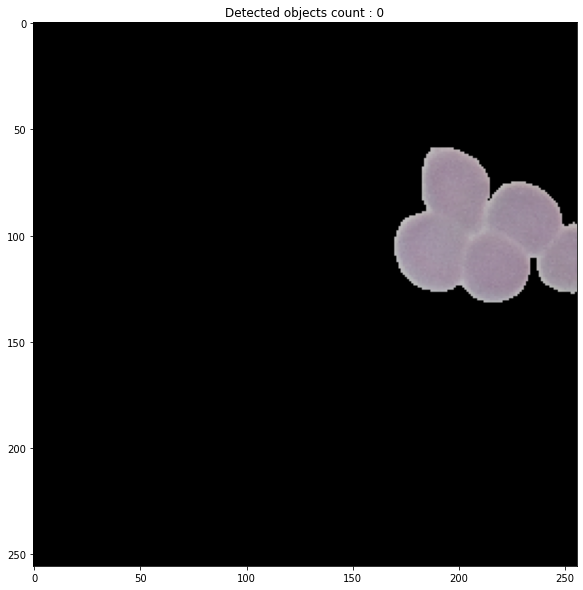

<Figure size 144x144 with 0 Axes>

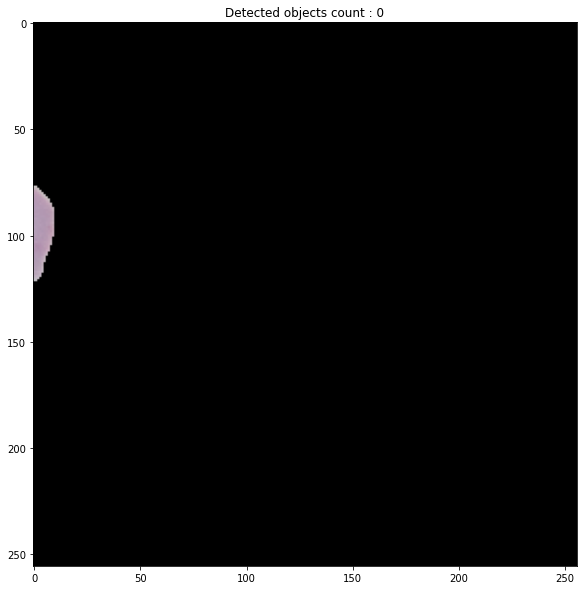

<Figure size 144x144 with 0 Axes>

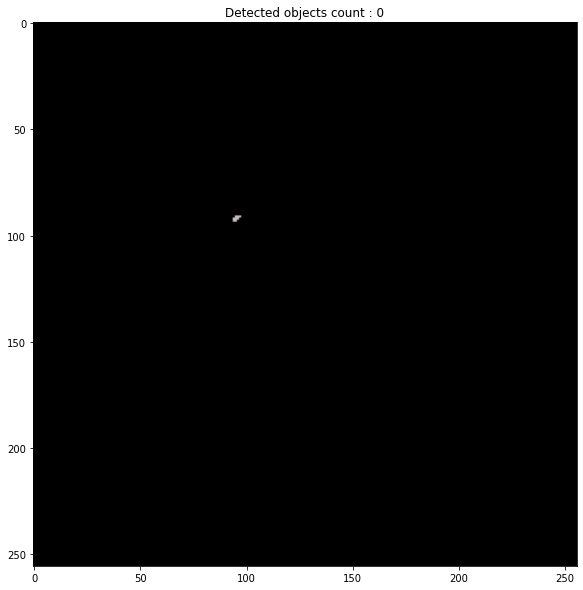

<Figure size 144x144 with 0 Axes>

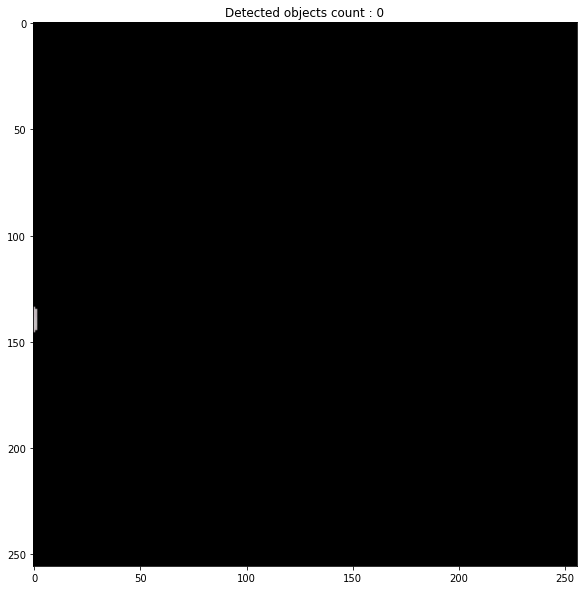

<Figure size 144x144 with 0 Axes>

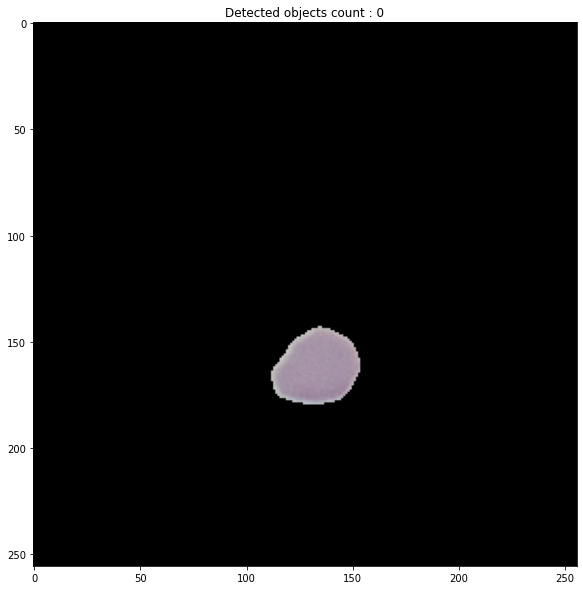

<Figure size 144x144 with 0 Axes>

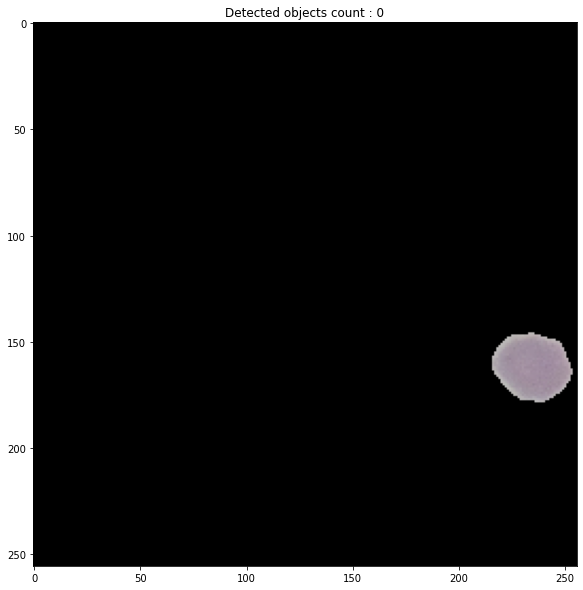

<Figure size 144x144 with 0 Axes>

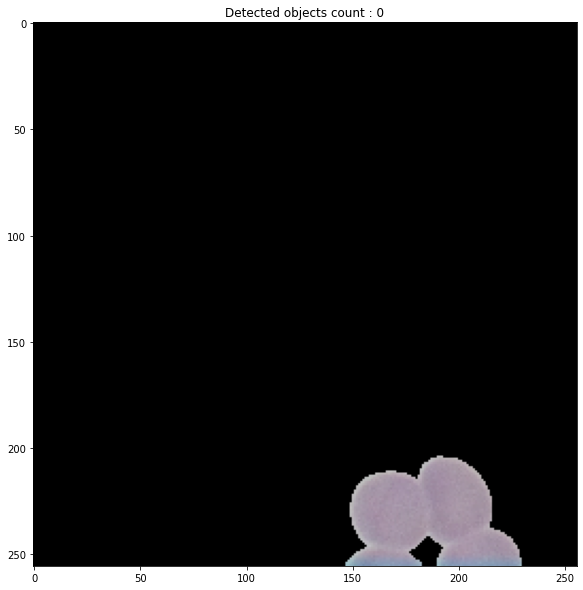

<Figure size 144x144 with 0 Axes>

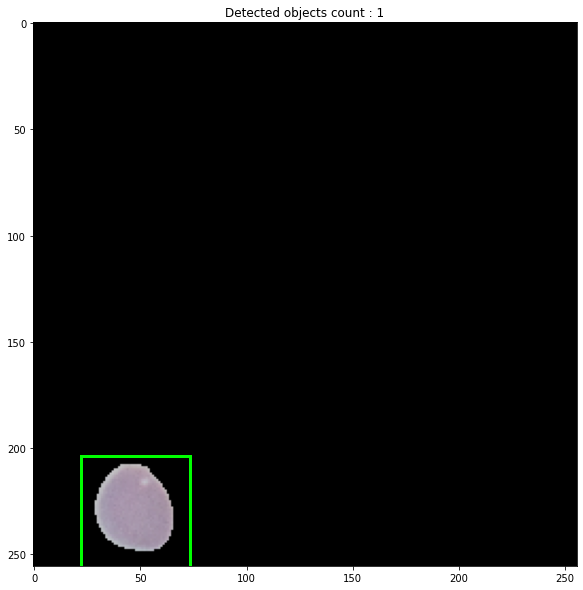

<Figure size 144x144 with 0 Axes>

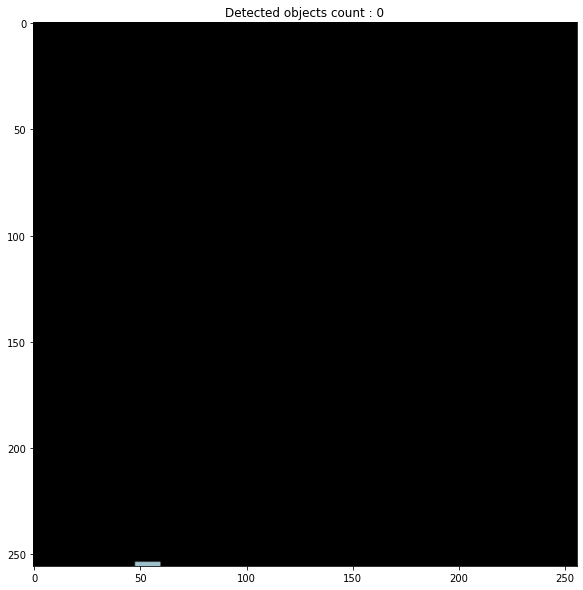

<Figure size 144x144 with 0 Axes>

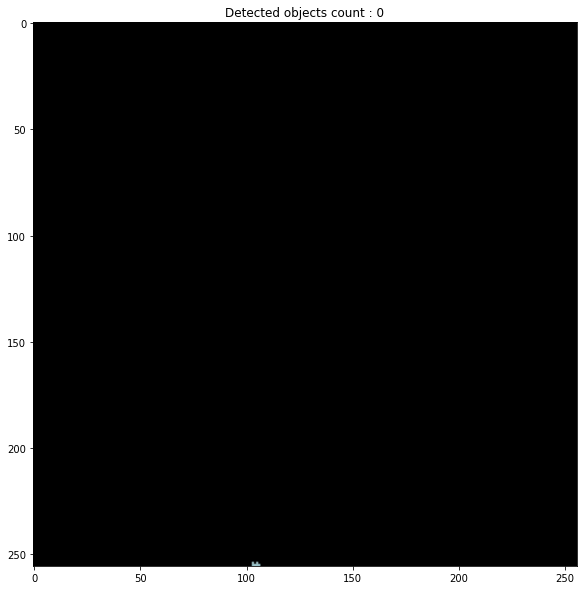

In [80]:
score_threshold  = 0.5
iou_threshold    = 0.45
for label in range(1,num_labels):
    component = np.where(np.where(labels == label, 1, 0)[...,None], imgs[ix], 0)
    pipeline.display_yolo(component, yolo_model, score_threshold, iou_threshold, plot = True)

<Figure size 144x144 with 0 Axes>

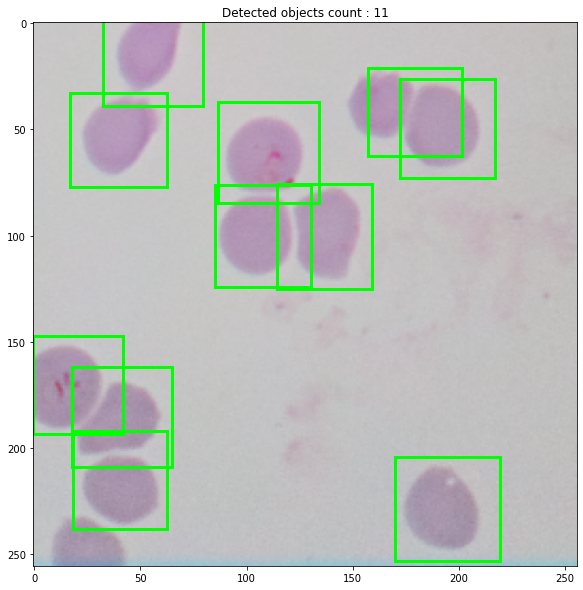

<Figure size 144x144 with 0 Axes>

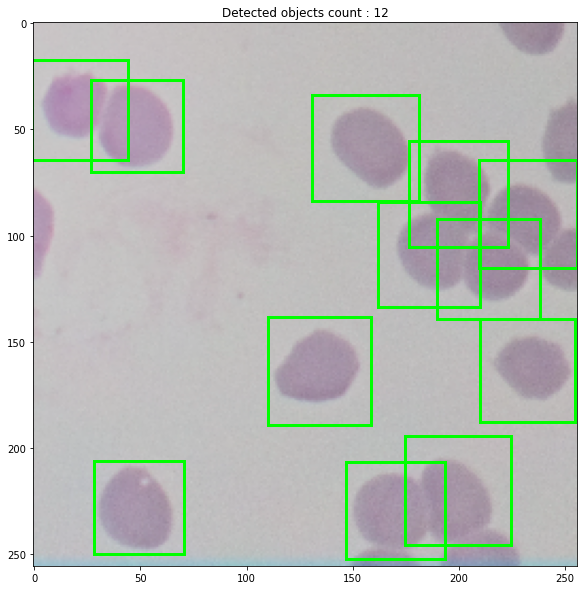

<Figure size 144x144 with 0 Axes>

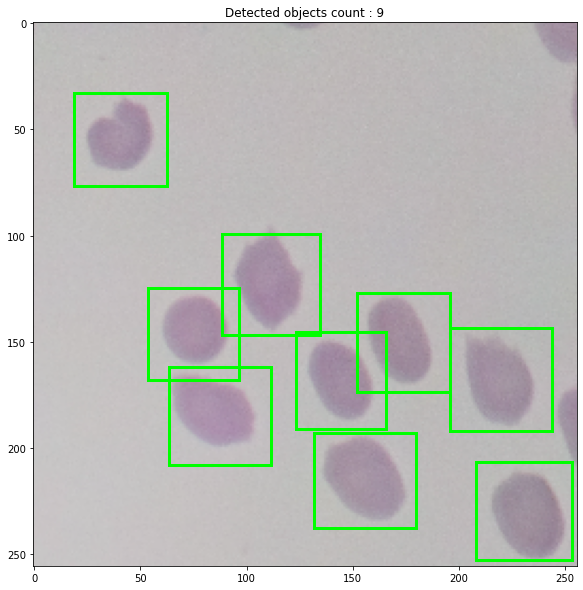

<Figure size 144x144 with 0 Axes>

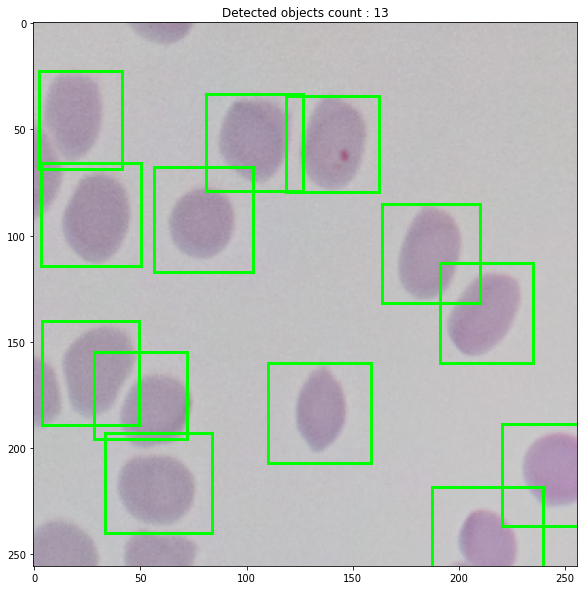

<Figure size 144x144 with 0 Axes>

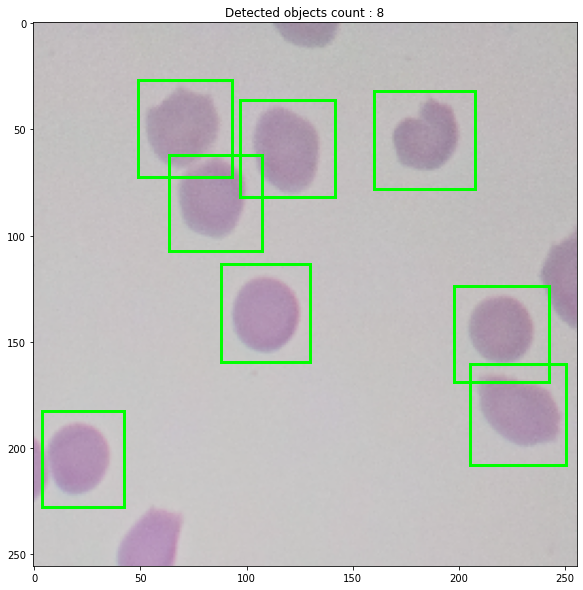

<Figure size 144x144 with 0 Axes>

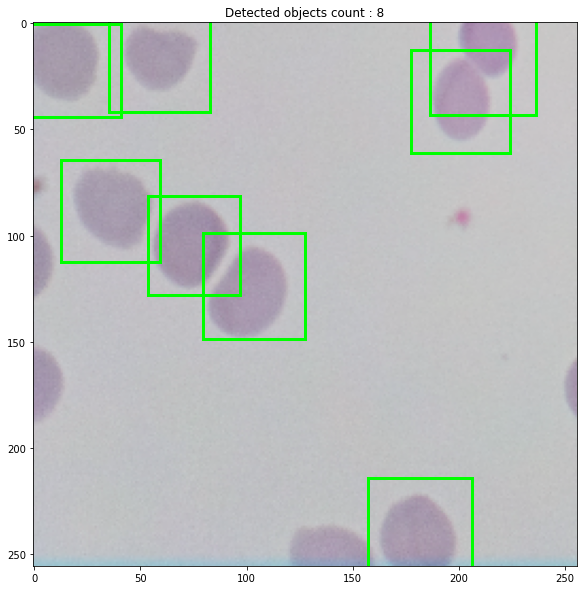

In [97]:
score_threshold  = 0.5
iou_threshold    = 0.45
for img in range(0, len(imgs)):
    pipeline.display_yolo(imgs[img], yolo_model, score_threshold, iou_threshold, plot = True)

<Figure size 144x144 with 0 Axes>

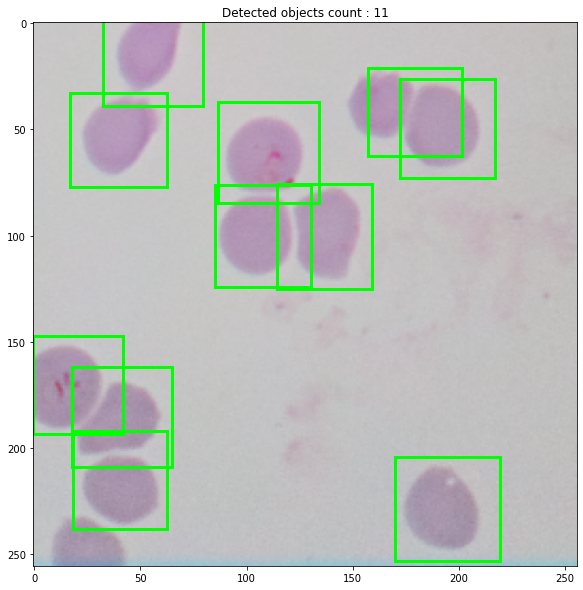

In [100]:
boxes, scores, classes = pipeline.display_yolo(imgs[0], yolo_model, score_threshold, iou_threshold, plot = True)

In [101]:
boxes

<tf.Tensor: shape=(11, 4), dtype=float32, numpy=
array([[172.1805    ,  26.040205  , 217.15205   ,  72.75452   ],
       [ 86.73071   ,  37.04427   , 134.14206   ,  84.85881   ],
       [114.44698   ,  75.64775   , 159.20279   , 124.92728   ],
       [ 17.059175  ,  32.88661   ,  62.44287   ,  77.16365   ],
       [ 32.584236  ,  -5.2010612 ,  79.310265  ,  38.967976  ],
       [157.25073   ,  21.29129   , 201.60342   ,  62.59636   ],
       [ 85.21329   ,  76.303894  , 130.17314   , 124.42763   ],
       [ -0.63342285, 147.23918   ,  41.829014  , 193.62184   ],
       [ 18.478048  , 191.85904   ,  62.478638  , 238.10321   ],
       [ 17.6762    , 162.06476   ,  64.73791   , 209.16629   ],
       [169.92308   , 204.31169   , 219.50697   , 253.09163   ]],
      dtype=float32)>

In [132]:
cropped_img =[]
for box in boxes.numpy():
    x1 = int(round(box[0]))
    y1 = int(round(box[1]))
    x2 = int(round(box[2]))
    y2 = int(round(box[3]))
    x1 = 0 if x1 < 0 else x1
    y1 = 0 if y1 < 0 else y1
    x2 = 0 if x2 < 0 else x2
    y2 = 0 if y2 < 0 else y2
    print( x1, x2, y1, y2)
    cropped_img.append(imgs[0][ y1:y2, x1:x2])

172 217 26 73
87 134 37 85
114 159 76 125
17 62 33 77
33 79 0 39
157 202 21 63
85 130 76 124
0 42 147 194
18 62 192 238
18 65 162 209
170 220 204 253



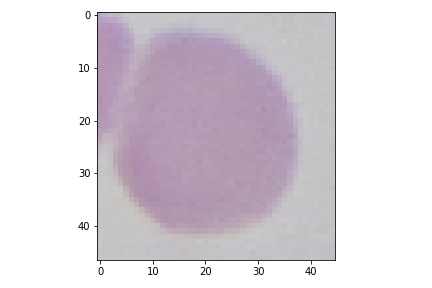
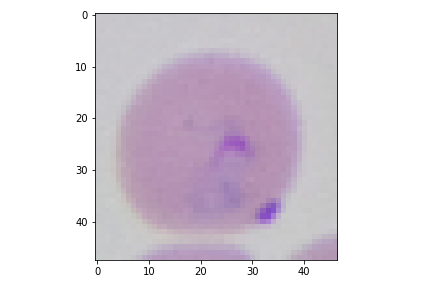
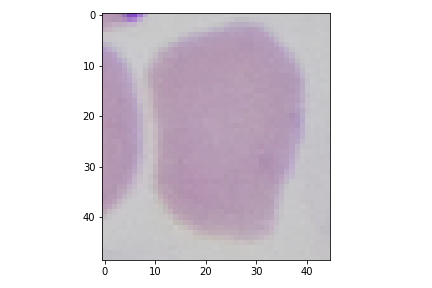
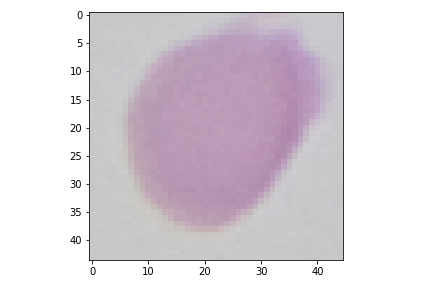
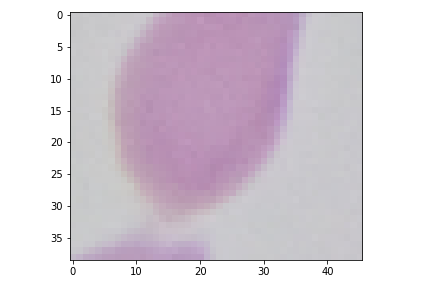
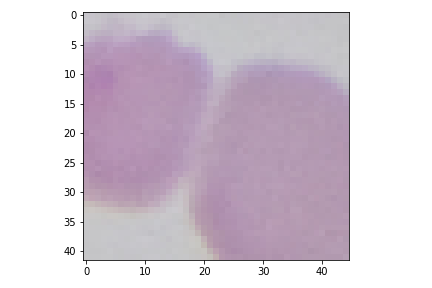
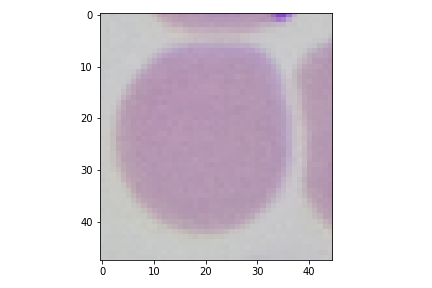
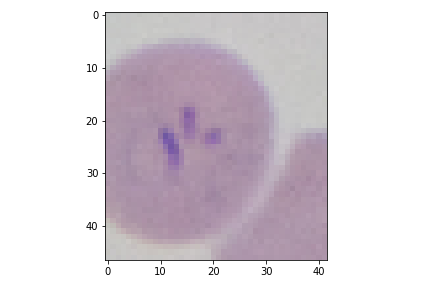
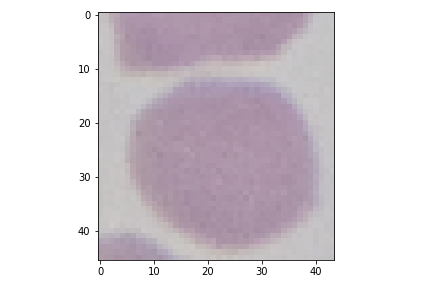
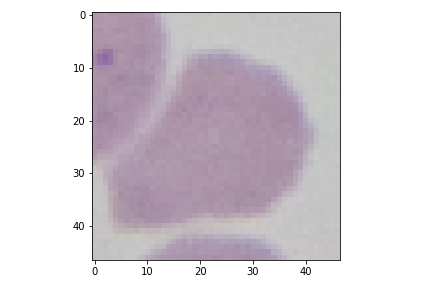
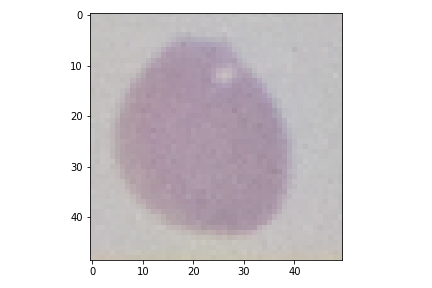

In [133]:

#pretty complicated just so we can plot next to each other
oPlot = FlowLayout() # create an empty FlowLayout

for img in cropped_img:
    oPlot.add_plot(imshow(img)) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell

oPlot.PassHtmlToCell()

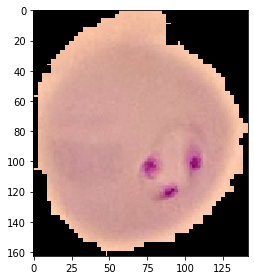

In [142]:
ref = '../data/cell_images/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png'
ref_img  = imread(ref)
imshow(ref_img)